### Multi step model (simple encoder-decoder)

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder. 
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [295]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.12f}'.format
np.set_printoptions(precision=12)
warnings.filterwarnings("ignore")

In [296]:
var_name = 'sqrt_A'
sat_var = 2
#'sqrt_A':[Del_n','sqrt_A','OMEGA_dot','e'],

In [369]:
Paras = {
    'M0':['M0', 'e','Del_n' , 'sqrt_A'],
    'e':['OMEGA','i0','omega','I_dot','Cus','Crs','e' , 'M0'],
    'sqrt_A':['Del_n','sqrt_A','OMEGA_dot','e'],
    'OMEGA':['OMEGA','e','i0','omega'],
    'i0':['e','i0','omega','OMEGA' ,'I_dot'],
    'omega':['omega','e','OMEGA','i0'],
    'I_dot':['I_dot','e','Crs','Cuc'],
    'Cic':['M0','Cic'],
    'Cis':['Cis'],
    'OMEGA_dot':['OMEGA_dot','sqrt_A','Crc','Del_n','Cus' , 'omega' ],
    'Cuc':['Cuc','e','sqrt_A','I_dot','Crs'],
    'Cus':['Cus','sqrt_A','OMEGA_dot','Crc','Del_n','Cus'],
    'Crc':['Crc','sqrt_A','OMEGA_dot','Cus','Del_n'],
    'Crs':['Crs','e','sqrt_A','I_dot','Cuc'],
    'Del_n':['Crc','sqrt_A','OMEGA_dot','Cus','Del_n'],
    'Codes' : ['Codes']    
}


# enter variable

In [370]:
var_name = 'sqrt_A'

In [371]:
df = pd.read_csv("hourinterpol_21.csv" , parse_dates = True)
a = pd.to_datetime(df['Epoch_Time_of_Clock'])
print(type(a[0]))
#df = df.drop(Paras['sqrt_A'],axis =1 )
df = df.loc[:,Paras[var_name]]
df.head()
#df = df.set_index(['Epoch_Time_of_Clock'])
df = df.set_index(a)
df.head()

<class 'pandas._libs.tslib.Timestamp'>


,Del_n,sqrt_A,OMEGA_dot,e
Epoch_Time_of_Clock,,,,
2017-11-02 00:00:00,0.000000005812,"5,153.602763320000",-0.000000009775,0.017215137700
2017-11-02 01:00:00,0.000000005701,"5,153.603491160000",-0.000000009578,0.017215219700
2017-11-02 02:00:00,0.000000005574,"5,153.604207810000",-0.000000009341,0.017215313100
2017-11-02 03:00:00,0.000000005429,"5,153.604885810000",-0.000000009065,0.017215417500
2017-11-02 04:00:00,0.000000005269,"5,153.605504350000",-0.000000008754,0.017215527100


In [372]:
#df  = df.iloc[1110:,:]


In [373]:
#train = df.iloc[:7200,:]
#train.tail()
#valid = df.iloc[10080:11520]
#valid = df.iloc[10080:12960]

#valid = df.iloc[7200 : 10080 ]

test = df.iloc[265:408,:]

# enter parameters and Satellite PRN

In [374]:
#df

# Enter number of entries per day

In [375]:
'''entry = 6
print(df.shape[0])
no_of_entries = df.shape[0]//entry
valid = (no_of_entries * 70)//100
test = (no_of_entries * 85)//100
indexes = df.index
#print(valid , test , indexes)
valid_start_dt = indexes[int(valid)*int(entry)] 
test_start_dt = indexes [int(test)*int(entry)] 
test_start_dt = str(test_start_dt)
valid_start_dt = str(valid_start_dt)
print(test_start_dt,valid_start_dt)
print(type(test_start_dt))'''
valid_start_dt = "2017-11-07 00:00:00"
test_start_dt = "2017-11-11 00:00:00"




Load data into Pandas dataframe

# enter lag and no. of outputs

In [376]:
"""total = len(df)
t = total*70/100
t = round(t)
indexes = df.index
valid_start_dt = str(indexes[t])
t = total*85/100
t = round(t)
test_start_dt = str(indexes[t])
print(valid_start_dt , test_start_dt)
"""
T = 24
HORIZON = 24

Create training set containing only the model features

In [377]:
train = df.copy()[df.index < valid_start_dt][Paras[var_name]]
train.head()

,Del_n,sqrt_A,OMEGA_dot,e
Epoch_Time_of_Clock,,,,
2017-11-02 00:00:00,0.000000005812,"5,153.602763320000",-0.000000009775,0.017215137700
2017-11-02 01:00:00,0.000000005701,"5,153.603491160000",-0.000000009578,0.017215219700
2017-11-02 02:00:00,0.000000005574,"5,153.604207810000",-0.000000009341,0.017215313100
2017-11-02 03:00:00,0.000000005429,"5,153.604885810000",-0.000000009065,0.017215417500
2017-11-02 04:00:00,0.000000005269,"5,153.605504350000",-0.000000008754,0.017215527100


In [378]:
train.shape
Paras[var_name]

['Del_n', 'sqrt_A', 'OMEGA_dot', 'e']

Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

# Enter variable to be predicted

In [379]:
from sklearn.preprocessing import StandardScaler
import pickle



y_scalar = StandardScaler()
y_scalar.fit(train[[var_name]])


X_scaler = StandardScaler()
train[Paras[var_name]] = X_scaler.fit_transform(train)




In [380]:
import pickle
file_x = open(var_name+'_X_scaler2_5D.pkl','wb')
pickle.dump(X_scaler, file_x)
            
file_y = open(var_name+'_y_scalar2_5D.pkl','wb')
pickle.dump(y_scalar, file_y)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [381]:
train[Paras[var_name]]

,Del_n,sqrt_A,OMEGA_dot,e
Epoch_Time_of_Clock,,,,
2017-11-02 00:00:00,1.505181550702,-1.081186087771,-1.173717565754,1.418618444885
2017-11-02 01:00:00,1.218139984341,-0.996367461719,-0.886528682951,1.461899971264
2017-11-02 02:00:00,0.885098301898,-0.912852859103,-0.542662576873,1.511198685458
2017-11-02 03:00:00,0.507873999439,-0.833842323130,-0.142503042343,1.566303458068
2017-11-02 04:00:00,0.091374955694,-0.761760941302,0.310211757329,1.624152912839
2017-11-02 05:00:00,-0.288412148649,-0.681124746094,0.734593184220,1.616341125151
2017-11-02 06:00:00,-0.609129899810,-0.561194210832,0.979410916658,1.418460097837
2017-11-02 07:00:00,-0.609129899810,-0.431512050618,1.046682455712,1.125676406584
2017-11-02 08:00:00,-0.609129899810,-0.380307862749,1.087668042214,1.042755335921


In [382]:
tensor_structure = {'X':(range(-T+1, 1), Paras[var_name])}
train_inputs = TimeSeriesTensor(train, var_name, HORIZON, {'X':(range(-T+1, 1), Paras[var_name])} ,freq = None)

In [383]:
train_inputs.dataframe

tensor                       target                                  \
feature                           y                                   
time step                       t+1             t+2             t+3   
Epoch_Time_of_Clock                                                   
2017-11-02 23:00:00 -0.983934373062 -0.900918539045 -0.824428648983   
2017-11-03 00:00:00 -0.900918539045 -0.824428648983 -0.758515449718   
2017-11-03 01:00:00 -0.824428648983 -0.758515449718 -0.706533975156   
2017-11-03 02:00:00 -0.758515449718 -0.706533975156 -0.655851862689   
2017-11-03 03:00:00 -0.706533975156 -0.655851862689 -0.579255926099   
2017-11-03 04:00:00 -0.655851862689 -0.579255926099 -0.481049792109   
2017-11-03 05:00:00 -0.579255926099 -0.481049792109 -0.398010651078   
2017-11-03 06:00:00 -0.481049792109 -0.398010651078 -0.374180467435   
2017-11-03 07:00:00 -0.398010651078 -0.374180467435 -0.456493597246   
2017-11-03 08:00:00 -0.374180467435 -0.456493597246 -0.623762863994   
2017-11-03 09:00:00 -0.456493597246 -0.623762863994 -0.788460209569   
2017-11-03 10:00:00 -0.623762863994 -0.788460209569 -0.906907258033   
2017-11-03 11:00:00 -0.788460209569 -0.906907258033 -0.982251611891   
2017-11-03 12:00:00 -0.906907258033 -0.982251611891 -1.019674404520   
2017-11-03 13:00:00 -0.982251611891 -1.019674404520 -1.024357934632   
2017-11-03 14:00:00 -1.019674404520 -1.024357934632 -1.001484501046   
2017-11-03 15:00:00 -1.024357934632 -1.001484501046 -0.956236402367   
2017-11-03 16:00:00 -1.001484501046 -0.956236402367 -0.893794771972   
2017-11-03 17:00:00 -0.956236402367 -0.893794771972 -0.819341908679   
2017-11-03 18:00:00 -0.893794771972 -0.819341908679 -0.738061276536   
2017-11-03 19:00:00 -0.819341908679 -0.738061276536 -0.655132843584   
2017-11-03 20:00:00 -0.738061276536 -0.655132843584 -0.575738908430   
2017-11-03 21:00:00 -0.655132843584 -0.575738908430 -0.505062935226   
2017-11-03 22:00:00 -0.575738908430 -0.505062935226 -0.448286057349   
2017-11-03 23:00:00 -0.505062935226 -0.448286057349 -0.410590573406   
2017-11-04 00:00:00 -0.448286057349 -0.410590573406 -0.397158782320   
2017-11-04 01:00:00 -0.410590573406 -0.397158782320 -0.411933053314   
2017-11-04 02:00:00 -0.397158782320 -0.411933053314 -0.430383994542   
2017-11-04 03:00:00 -0.411933053314 -0.430383994542 -0.401746754024   
2017-11-04 04:00:00 -0.430383994542 -0.401746754024 -0.325698530519   
...                             ...             ...             ...   
2017-11-04 18:00:00  0.051532495383  0.145828889526  0.231685840131   
2017-11-04 19:00:00  0.145828889526  0.231685840131  0.303231162221   
2017-11-04 20:00:00  0.231685840131  0.303231162221  0.354593837320   
2017-11-04 21:00:00  0.303231162221  0.354593837320  0.379900515964   
2017-11-04 22:00:00  0.354593837320  0.379900515964  0.373282509394   
2017-11-04 23:00:00  0.379900515964  0.373282509394  0.328865303233   
2017-11-05 00:00:00  0.373282509394  0.328865303233  0.240779043813   
2017-11-05 01:00:00  0.328865303233  0.240779043813  0.105796884798   
2017-11-05 02:00:00  0.240779043813  0.105796884798 -0.018474568537   
2017-11-05 03:00:00  0.105796884798 -0.018474568537 -0.019923095079   
2017-11-05 04:00:00 -0.018474568537 -0.019923095079  0.070605731972   
2017-11-05 05:00:00 -0.019923095079  0.070605731972  0.083772989300   
2017-11-05 06:00:00  0.070605731972  0.083772989300  0.007401964660   
2017-11-05 07:00:00  0.083772989300  0.007401964660 -0.011770326448   
2017-11-05 08:00:00  0.007401964660 -0.011770326448  0.074803312380   
2017-11-05 09:00:00 -0.011770326448  0.074803312380  0.211528830612   
2017-11-05 10:00:00  0.074803312380  0.211528830612  0.364939789281   
2017-11-05 11:00:00  0.211528830612  0.364939789281  0.528274844045   
2017-11-05 12:00:00  0.364939789281  0.528274844045  0.695935667424   
2017-11-05 13:00:00  0.528274844045  0.695935667424  0.862320435721   
2017-11-05 14:00:00  0.695935667424  0.862320435721  1.021830821246   
2017-11-05 15:00:00  0.8

In [384]:
train_inputs['target'].shape

(73, 24)

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [385]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][Paras[var_name]]
valid[Paras[var_name]] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, var_name, HORIZON, tensor_structure,freq = None)
valid_inputs.dataframe.head()

tensor                      target                                \
feature                          y                                 
time step                      t+1            t+2            t+3   
Epoch_Time_of_Clock                                                
2017-11-07 00:00:00 2.247681616981 1.992504388840 1.664726034140   
2017-11-07 01:00:00 1.992504388840 1.664726034140 1.266846222446   
2017-11-07 02:00:00 1.664726034140 1.266846222446 0.950046603081   
2017-11-07 03:00:00 1.266846222446 0.950046603081 0.994304156464   
2017-11-07 04:00:00 0.950046603081 0.994304156464 1.228427057846   

tensor                                                            \
feature                                                            
time step                      t+4            t+5            t+6   
Epoch_Time_of_Clock                                                
2017-11-07 00:00:00 1.266846222446 0.950046603081 0.994304156464   
2017-11-07 01:00:00 0.950046603081 0.994304156464 1.228427057846   
2017-11-07 02:00:00 0.994304156464 1.228427057846 1.052850031348   
2017-11-07 03:00:00 1.228427057846 1.052850031348 0.520888873883   
2017-11-07 04:00:00 1.052850031348 0.520888873883 0.334595315137   

tensor                                                            \
feature                                                            
time step                      t+7            t+8            t+9   
Epoch_Time_of_Clock                                                
2017-11-07 00:00:00 1.228427057846 1.052850031348 0.520888873883   
2017-11-07 01:00:00 1.052850031348 0.520888873883 0.334595315137   
2017-11-07 02:00:00 0.520888873883 0.334595315137 0.672279120576   
2017-11-07 03:00:00 0.334595315137 0.672279120576 1.167541165962   
2017-11-07 04:00:00 0.672279120576 1.167541165962 1.620452165645   

tensor                                  ...                    X  \
feature                                 ...                    e   
time step                     t+10      ...                  t-9   
Epoch_Time_of_Clock                     ...                        
2017-11-07 00:00:00 0.334595315137      ...       0.850416455279   
2017-11-07 01:00:00 0.672279120576      ...       0.882033082475   
2017-11-07 02:00:00 1.167541165962      ...       0.959781482910   
2017-11-07 03:00:00 1.620452165645      ...       1.081022539123   
2017-11-07 04:00:00 2.021601941591      ...       1.242906004253   

tensor                                                            \
feature                                                            
time step                      t-8            t-7            t-6   
Epoch_Time_of_Clock                                                
2017-11-07 00:00:00 0.882033082475 0.959781482910 1.081022539123   
2017-11-07 01:00:00 0.959781482910 1.081022539123 1.242906004253   
2017-11-07 02:00:00 1.081022539123 1.242906004253 1.442739978489   
2017-11-07 03:00:00 1.242906004253 1.442739978489 1.677832562020   
2017-11-07 04:00:00 1.442739978489 1.677832562020 1.945386290335   

tensor                                                            \
feature                                                            
time step                      t-5            t-4            t-3   
Epoch_Time_of_Clock                                                
2017-11-07 00:00:00 1.242906004253 1.442739978489 1.677832562020   
2017-11-07 01:00:00 1.442739978489 1.677832562020 1.945386290335   
2017-11-07 02:00:00 1.677832562020 1.945386290335 2.242709263623   
2017-11-07 03:00:00 1.945386290335 2.242709263623 2.567056799726   
2017-11-07 04:00:00 2.242709263623 2.567056799726 2.915631434130   

tensor                                                            
feature                                                           
time step                      t-2            t-1              t  
Epoch_Time_of_Clock                                               
2017-11-07 00:00:00 1.945386290335 2.242709263623 2.56


## Implement the RNN

We will implement a RNN forecasting model with the following structure:

In [386]:
#Image('./images/simple_encoder_decoder.png')

In [387]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping ,ModelCheckpoint

In [388]:
LATENT_DIM = 64
BATCH_SIZE = 64
EPOCHS = 1000

In [389]:
model = Sequential()
model.add(LSTM(LATENT_DIM, input_shape=(T,len(Paras[var_name]) ) , return_sequences = True))
model.add(LSTM(LATENT_DIM))
model.add(RepeatVector(HORIZON))
model.add(LSTM(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

In [390]:
model.compile(optimizer='RMSprop', loss='mse')

In [391]:



model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 24, 64)            17664     
_________________________________________________________________
lstm_29 (LSTM)               (None, 64)                33024     
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 24, 64)            0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 24, 64)            33024     
_________________________________________________________________
time_distributed_10 (TimeDis (None, 24, 1)             65        
_________________________________________________________________
flatten_10 (Flatten)         (None, 24)                0         
Total params: 83,777
Trainable params: 83,777
Non-trainable params: 0
_________________________________________________________________


In [392]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=500)

In [393]:
best_val = ModelCheckpoint(str(sat_var) +'_' +  var_name + '_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [394]:
history = model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Train on 73 samples, validate on 72 samples
Epoch 1/1000
73/73 [==============================] - 3s 47ms/step - loss: 0.5302 - val_loss: 7.7308
Epoch 2/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.1957 - val_loss: 8.5922
Epoch 3/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.4504 - val_loss: 7.6581
Epoch 4/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.2002 - val_loss: 7.3760
Epoch 5/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.1808 - val_loss: 7.2686
Epoch 6/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.1781 - val_loss: 7.1347
Epoch 7/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.1729 - val_loss: 7.0323
Epoch 8/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.1689 - val_loss: 6.9434
Epoch 9/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.1647 - val_loss: 6.8741
Epoch 10/1000
73/73 [==============================] - 

73/73 [==============================] - 0s 1ms/step - loss: 0.0567 - val_loss: 7.0492
Epoch 82/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 7.7579
Epoch 83/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0710 - val_loss: 7.0862
Epoch 84/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0823 - val_loss: 7.9528
Epoch 85/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0779 - val_loss: 7.0272
Epoch 86/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0656 - val_loss: 8.0283
Epoch 87/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.0663 - val_loss: 6.9991
Epoch 88/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 7.9120
Epoch 89/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0615 - val_loss: 7.1628
Epoch 90/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0643 - val_loss: 7.6077
Epoc

73/73 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 8.0568
Epoch 162/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0356 - val_loss: 8.9687
Epoch 163/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0442 - val_loss: 7.8777
Epoch 164/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0386 - val_loss: 8.3722
Epoch 165/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 8.0579
Epoch 166/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0348 - val_loss: 9.0008
Epoch 167/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0446 - val_loss: 7.7292
Epoch 168/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.0449 - val_loss: 8.8497
Epoch 169/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0440 - val_loss: 7.7637
Epoch 170/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0477 - val_loss: 8.

73/73 [==============================] - 0s 1ms/step - loss: 0.0190 - val_loss: 7.9505
Epoch 242/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0213 - val_loss: 7.6802
Epoch 243/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0247 - val_loss: 8.1816
Epoch 244/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 7.6175
Epoch 245/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0261 - val_loss: 8.2129
Epoch 246/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0258 - val_loss: 7.5657
Epoch 247/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0260 - val_loss: 8.2302
Epoch 248/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 7.4451
Epoch 249/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0241 - val_loss: 8.2138
Epoch 250/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0232 - val_loss: 7.

73/73 [==============================] - 0s 1ms/step - loss: 0.0127 - val_loss: 7.0248
Epoch 322/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0162 - val_loss: 6.5715
Epoch 323/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0258 - val_loss: 7.4370
Epoch 324/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 6.7182
Epoch 325/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0183 - val_loss: 7.1845
Epoch 326/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0159 - val_loss: 6.8833
Epoch 327/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0169 - val_loss: 6.9550
Epoch 328/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0187 - val_loss: 6.8769
Epoch 329/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 6.3836
Epoch 330/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 6.

73/73 [==============================] - 0s 1ms/step - loss: 0.0129 - val_loss: 6.5247
Epoch 402/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 6.9963
Epoch 403/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0119 - val_loss: 6.7891
Epoch 404/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.0122 - val_loss: 6.4467
Epoch 405/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0151 - val_loss: 7.3126
Epoch 406/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0178 - val_loss: 6.2390
Epoch 407/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0197 - val_loss: 7.0563
Epoch 408/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0226 - val_loss: 6.6255
Epoch 409/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 6.4304
Epoch 410/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0176 - val_loss: 6.

73/73 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 6.2354
Epoch 482/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0158 - val_loss: 6.4339
Epoch 483/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0147 - val_loss: 6.2405
Epoch 484/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0125 - val_loss: 6.5749
Epoch 485/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0126 - val_loss: 6.1644
Epoch 486/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 6.6675
Epoch 487/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0124 - val_loss: 6.1774
Epoch 488/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 6.4725
Epoch 489/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0119 - val_loss: 6.3962
Epoch 490/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 6.

73/73 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 6.0887
Epoch 562/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 6.2962
Epoch 563/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0106 - val_loss: 6.1527
Epoch 564/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0115 - val_loss: 6.1393
Epoch 565/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0121 - val_loss: 6.2111
Epoch 566/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0137 - val_loss: 5.9524
Epoch 567/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0133 - val_loss: 6.4025
Epoch 568/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0136 - val_loss: 5.7812
Epoch 569/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0129 - val_loss: 6.6463
Epoch 570/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0125 - val_loss: 5.

73/73 [==============================] - 0s 1ms/step - loss: 0.0095 - val_loss: 5.3416
Epoch 642/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0100 - val_loss: 6.1293
Epoch 643/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.0108 - val_loss: 5.2775
Epoch 644/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 5.9908
Epoch 645/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0133 - val_loss: 5.5588
Epoch 646/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0195 - val_loss: 5.5171
Epoch 647/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0164 - val_loss: 5.7375
Epoch 648/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0161 - val_loss: 5.7282
Epoch 649/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 5.7076
Epoch 650/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0103 - val_loss: 5.

73/73 [==============================] - 0s 2ms/step - loss: 0.0092 - val_loss: 5.2706
Epoch 722/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0097 - val_loss: 5.4215
Epoch 723/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 5.4514
Epoch 724/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 5.2902
Epoch 725/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 5.4689
Epoch 726/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 5.2830
Epoch 727/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0104 - val_loss: 5.5521
Epoch 728/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 5.2035
Epoch 729/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0116 - val_loss: 5.7322
Epoch 730/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 5.

73/73 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 5.0528
Epoch 802/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 5.2539
Epoch 803/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 4.8731
Epoch 804/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 5.4013
Epoch 805/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0085 - val_loss: 4.8181
Epoch 806/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 5.1204
Epoch 807/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0142 - val_loss: 5.1843
Epoch 808/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0164 - val_loss: 5.0045
Epoch 809/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 5.0050
Epoch 810/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 5.

73/73 [==============================] - 0s 1ms/step - loss: 0.0069 - val_loss: 4.6668
Epoch 882/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0065 - val_loss: 5.0016
Epoch 883/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 4.8176
Epoch 884/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0114 - val_loss: 4.5813
Epoch 885/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0126 - val_loss: 5.0120
Epoch 886/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0095 - val_loss: 4.5868
Epoch 887/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 4.9329
Epoch 888/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 4.5970
Epoch 889/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 5.0683
Epoch 890/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 4.

73/73 [==============================] - 0s 1ms/step - loss: 0.0065 - val_loss: 4.5472
Epoch 962/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 4.8132
Epoch 963/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 4.4988
Epoch 964/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0080 - val_loss: 4.6949
Epoch 965/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0093 - val_loss: 4.7586
Epoch 966/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0093 - val_loss: 4.4010
Epoch 967/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 4.7842
Epoch 968/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 4.4248
Epoch 969/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 4.7605
Epoch 970/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 4.

In [395]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights(str(sat_var) +'_' +  var_name + '_{:02d}.h5'.format(best_epoch))

In [355]:
"""model.fit(valid_inputs['X'],
          valid_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=100,
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)"""

"model.fit(valid_inputs['X'],\n          valid_inputs['target'],\n          batch_size=BATCH_SIZE,\n          epochs=100,\n          callbacks=[earlystop ,best_val],\n          verbose=1 , shuffle = False)"

## Evaluate the model

In [396]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = df.copy()[test_start_dt:][Paras[var_name]]
test[Paras[var_name]] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, var_name, HORIZON, tensor_structure,freq =None)
test_inputs.dataframe.head()

tensor                      target                                \
feature                          y                                 
time step                      t+1            t+2            t+3   
Epoch_Time_of_Clock                                                
2017-11-11 23:00:00 0.911037772813 0.865734902867 0.834112042867   
2017-11-12 00:00:00 0.865734902867 0.834112042867 0.820999556911   
2017-11-12 01:00:00 0.834112042867 0.820999556911 0.831077479004   
2017-11-12 02:00:00 0.820999556911 0.831077479004 0.865597391875   
2017-11-12 03:00:00 0.831077479004 0.865597391875 0.919772049556   

tensor                                                            \
feature                                                            
time step                      t+4            t+5            t+6   
Epoch_Time_of_Clock                                                
2017-11-11 23:00:00 0.820999556911 0.831077479004 0.865597391875   
2017-11-12 00:00:00 0.831077479004 0.865597391875 0.919772049556   
2017-11-12 01:00:00 0.865597391875 0.919772049556 0.928614703709   
2017-11-12 02:00:00 0.919772049556 0.928614703709 0.774707307216   
2017-11-12 03:00:00 0.928614703709 0.774707307216 0.513147472893   

tensor                                                            \
feature                                                            
time step                      t+7            t+8            t+9   
Epoch_Time_of_Clock                                                
2017-11-11 23:00:00 0.919772049556 0.928614703709 0.774707307216   
2017-11-12 00:00:00 0.928614703709 0.774707307216 0.513147472893   
2017-11-12 01:00:00 0.774707307216 0.513147472893 0.366450079097   
2017-11-12 02:00:00 0.513147472893 0.366450079097 0.387423996906   
2017-11-12 03:00:00 0.366450079097 0.387423996906 0.454369693944   

tensor                                   ...                     X  \
feature                                  ...                     e   
time step                     t+10       ...                   t-9   
Epoch_Time_of_Clock                      ...                         
2017-11-11 23:00:00 0.513147472893       ...       23.874921712900   
2017-11-12 00:00:00 0.366450079097       ...       23.927967973889   
2017-11-12 01:00:00 0.387423996906       ...       23.986134122756   
2017-11-12 02:00:00 0.454369693944       ...       24.049103465404   
2017-11-12 03:00:00 0.502633711023       ...       24.116664872436   

tensor                                                               \
feature                                                               
time step                       t-8             t-7             t-6   
Epoch_Time_of_Clock                                                   
2017-11-11 23:00:00 23.927967973889 23.986134122756 24.049103465404   
2017-11-12 00:00:00 23.986134122756 24.049103465404 24.116664872436   
2017-11-12 01:00:00 24.049103465404 24.116664872436 24.188607214454   
2017-11-12 02:00:00 24.116664872436 24.188607214454 24.264719362063   
2017-11-12 03:00:00 24.188607214454 24.264719362063 24.344737403517   

tensor                                                               \
feature                                                               
time step                       t-5             t-4             t-3   
Epoch_Time_of_Clock                                                   
2017-11-11 23:00:00 24.116664872436 24.188607214454 24.264719362063   
2017-11-12 00:00:00 24.188607214454 24.264719362063 24.344737403517   
2017-11-12 01:00:00 24.264719362063 24.344737403517 24.428450209416   
2017-11-12 02:00:00 24.344737403517 24.428450209416 24.515593868018   
2017-11-12 03:00:00 24.428450209416 24.515593868018 24.605957249923   

tensor                                                               
feature                                                              
time step                       t-2             t-1               t  
Epoch_Time_of_Clock                     

In [397]:
test_inputs.dataframe.head(50)

tensor                      target                                \
feature                          y                                 
time step                      t+1            t+2            t+3   
Epoch_Time_of_Clock                                                
2017-11-11 23:00:00 0.911037772813 0.865734902867 0.834112042867   
2017-11-12 00:00:00 0.865734902867 0.834112042867 0.820999556911   
2017-11-12 01:00:00 0.834112042867 0.820999556911 0.831077479004   
2017-11-12 02:00:00 0.820999556911 0.831077479004 0.865597391875   
2017-11-12 03:00:00 0.831077479004 0.865597391875 0.919772049556   
2017-11-12 04:00:00 0.865597391875 0.919772049556 0.928614703709   
2017-11-12 05:00:00 0.919772049556 0.928614703709 0.774707307216   
2017-11-12 06:00:00 0.928614703709 0.774707307216 0.513147472893   
2017-11-12 07:00:00 0.774707307216 0.513147472893 0.366450079097   
2017-11-12 08:00:00 0.513147472893 0.366450079097 0.387423996906   
2017-11-12 09:00:00 0.366450079097 0.387423996906 0.454369693944   
2017-11-12 10:00:00 0.387423996906 0.454369693944 0.502633711023   
2017-11-12 11:00:00 0.454369693944 0.502633711023 0.532326756011   
2017-11-12 12:00:00 0.502633711023 0.532326756011 0.546371519780   
2017-11-12 13:00:00 0.532326756011 0.546371519780 0.547691858114   
2017-11-12 14:00:00 0.546371519780 0.547691858114 0.539211626904   
2017-11-12 15:00:00 0.547691858114 0.539211626904 0.523854682356   
2017-11-12 16:00:00 0.539211626904 0.523854682356 0.504544880255   
2017-11-12 17:00:00 0.523854682356 0.504544880255 0.484204911369   
2017-11-12 18:00:00 0.504544880255 0.484204911369 0.465758631480   
2017-11-12 19:00:00 0.484204911369 0.465758631480 0.452131062026   
2017-11-12 20:00:00 0.465758631480 0.452131062026 0.446244893667   
2017-11-12 21:00:00 0.452131062026 0.446244893667 0.451023982294   
2017-11-12 22:00:00 0.446244893667 0.451023982294 0.469392183902   
2017-11-12 23:00:00 0.451023982294 0.469392183902 0.504273354382   
2017-11-13 00:00:00 0.469392183902 0.504273354382 0.558591349835   
2017-11-13 01:00:00 0.504273354382 0.558591349835 0.633929876913   
2017-11-13 02:00:00 0.558591349835 0.633929876913 0.701059698759   
2017-11-13 03:00:00 0.633929876913 0.701059698759 0.702019944820   
2017-11-13 04:00:00 0.701059698759 0.702019944820 0.625316796262   
2017-11-13 05:00:00 0.702019944820 0.625316796262 0.507257808424   
2017-11-13 06:00:00 0.625316796262 0.507257808424 0.386125800251   
2017-11-13 07:00:00 0.507257808424 0.386125800251 0.298774874835   
2017-11-13 08:00:00 0.386125800251 0.298774874835 0.251601622694   
2017-11-13 09:00:00 0.298774874835 0.251601622694 0.221095165315   
2017-11-13 10:00:00 0.251601622694 0.221095165315 0.194808429918   
2017-11-13 11:00:00 0.221095165315 0.194808429918 0.172686645235   
2017-11-13 12:00:00 0.194808429918 0.172686645235 0.155211099527   
2017-11-13 13:00:00 0.172686645235 0.155211099527 0.142865411934   
2017-11-13 14:00:00 0.155211099527 0.142865411934 0.136132036157   
2017-11-13 15:00:00 0.142865411934 0.136132036157 0.135493426002   
2017-11-13 16:00:00 0.136132036157 0.135493426002 0.141433200292   
2017-11-13 17:00:00 0.135493426002 0.141433200292 0.154433812939   
2017-11-13 18:00:00 0.141433200292 0.154433812939 0.174976552309   
2017-11-13 19:00:00 0.154433812939 0.174976552309 0.203546202772   
2017-11-13 20:00:00 0.174976552309 0.203546202772 0.240624052587   
2017-11-13 21:00:00 0.203546202772 0.240624052587 0.286693721000   
2017-11-13 22:00:00 0.240624052587 0.286693721000 0.342237661608   
2017-11-13 23:00:00 0.286693721000 0.342237661608 0.407738328215   
2017-11-14 00:00:00 0.342237661608 0.407738328215 0.483678174416   

tensor                                                            \
feature                                                            
time step                      t+4            t+5            t+6   
Epoch_Time_of_Clock                                                
2017-11-11 23:00:00 0.820999556911 0.831077479004 0.865

In [398]:
train_inputs.dataframe.shape

(73, 120)

In [399]:
test_inputs.dataframe.shape

(413, 120)

In [400]:
predictions = model.predict(test_inputs['X'])

In [401]:
predictions

array([[-0.6695065 , -0.6610995 , -0.66168535, ..., -0.609653  ,
        -0.60448104, -0.6091077 ],
       [-0.66886765, -0.65974015, -0.6603616 , ..., -0.6061164 ,
        -0.6007723 , -0.6053651 ],
       [-0.67074007, -0.66165715, -0.6624474 , ..., -0.60358894,
        -0.597909  , -0.6024013 ],
       ...,
       [-0.8100533 , -0.787836  , -0.75512904, ..., -0.64519125,
        -0.64329505, -0.6541335 ],
       [-0.81016123, -0.78811485, -0.7554874 , ..., -0.64525795,
        -0.64341265, -0.654296  ],
       [-0.8102536 , -0.7884342 , -0.755917  , ..., -0.64524335,
        -0.64345974, -0.6544097 ]], dtype=float32)

In [402]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scalar)
print(eval_df.head())
print(eval_df.tail())
print(eval_df.shape)


            timestamp    h         prediction             actual
0 2017-11-11 23:00:00  t+1 5,153.606295997811 5,153.619858860000
1 2017-11-12 00:00:00  t+1 5,153.606301479805 5,153.619470110000
2 2017-11-12 01:00:00  t+1 5,153.606285412316 5,153.619198750000
3 2017-11-12 02:00:00  t+1 5,153.606250840667 5,153.619086230000
4 2017-11-12 03:00:00  t+1 5,153.606205343392 5,153.619172710000
               timestamp     h         prediction             actual
9907 2017-11-28 23:00:00  t+24 5,153.606429845820 5,153.640982110000
9908 2017-11-29 00:00:00  t+24 5,153.606429271946 5,153.640030800000
9909 2017-11-29 01:00:00  t+24 5,153.606427915513 5,153.638027970000
9910 2017-11-29 02:00:00  t+24 5,153.606426521231 5,153.634829070000
9911 2017-11-29 03:00:00  t+24 5,153.606425545335 5,153.630289570000
(9912, 4)


In [403]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1    0.000003775600
t+10   0.000004254101
t+11   0.000004231968
t+12   0.000004186433
t+13   0.000004127138
t+14   0.000004061570
t+15   0.000003994184
t+16   0.000003927071
t+17   0.000003861557
t+18   0.000003799561
t+19   0.000003744131
t+2    0.000003752474
t+20   0.000003699079
t+21   0.000003668124
t+22   0.000003654293
t+23   0.000003659968
t+24   0.000003687086
t+3    0.000003716234
t+4    0.000003759169
t+5    0.000003852930
t+6    0.000003971628
t+7    0.000004091167
t+8    0.000004187131
t+9    0.000004242056
Name: APE, dtype: float64

# prediction result

In [404]:
mape(eval_df['prediction'], eval_df['actual'])
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(eval_df['prediction'], eval_df['actual'])
a

0.02016456630346303

In [405]:
eval_df['prediction']

0      5,153.606295997811
1      5,153.606301479805
2      5,153.606285412316
3      5,153.606250840667
4      5,153.606205343392
5      5,153.606162241355
6      5,153.606128837406
7      5,153.606103024263
8      5,153.606080621127
9      5,153.606065614437
10     5,153.606059935525
11     5,153.606055382371
12     5,153.606042976023
13     5,153.606020385175
14     5,153.605992509251
15     5,153.605962125052
16     5,153.605929716946
17     5,153.605898645324
18     5,153.605874076600
19     5,153.605861453387
20     5,153.605864450633
21     5,153.605883652443
22     5,153.605915238610
23     5,153.605951740055
24     5,153.605983817749
25     5,153.606002465121
26     5,153.606002952557
27     5,153.605987552543
28     5,153.605967142626
29     5,153.605947456960
              ...        
9882   5,153.606379920702
9883   5,153.606379672126
9884   5,153.606379101318
9885   5,153.606378477319
9886   5,153.606377196585
9887   5,153.606375561909
9888   5,153.606374502132
9889   5,153

In [406]:
a = eval_df.drop(['timestamp'] , axis = 1)

In [407]:
a.head()

,h,prediction,actual,APE
0,t+1,"5,153.606295997811","5,153.619858860000",0.000002631716
1,t+1,"5,153.606301479805","5,153.619470110000",0.000002555220
2,t+1,"5,153.606285412316","5,153.619198750000",0.000002505683
3,t+1,"5,153.606250840667","5,153.619086230000",0.000002490558
4,t+1,"5,153.606205343392","5,153.619172710000",0.000002516167


Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

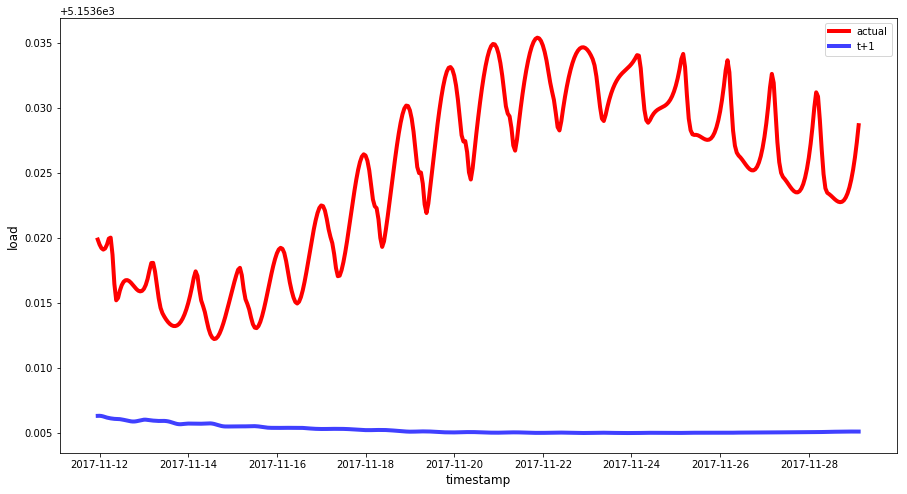

In [408]:
plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[ (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
#ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
#ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.savefig('sqrt_A.png')
plt.show()

# take input here

In [409]:
a = df.iloc[456:480  , :]
Actual = df.iloc[480:504,:]

In [410]:
new_df = pd.DataFrame()

In [411]:
columns = Paras[var_name]

In [412]:
for key , value in enumerate(columns):
    new_df[value] = a[value]

In [413]:
new_df = new_df.dropna( how = 'any')

In [414]:
new_df

,Del_n,sqrt_A,OMEGA_dot,e
Epoch_Time_of_Clock,,,,
2017-11-21 00:00:00,0.000000004655,"5,153.634625130000",-0.000000008519,0.017310123800
2017-11-21 01:00:00,0.000000004594,"5,153.634155670000",-0.000000008363,0.017310433200
2017-11-21 02:00:00,0.000000004531,"5,153.633448140000",-0.000000008186,0.017310794400
2017-11-21 03:00:00,0.000000004465,"5,153.632488750000",-0.000000008000,0.017311213500
2017-11-21 04:00:00,0.000000004397,"5,153.631276730000",-0.000000007778,0.017311693800
2017-11-21 05:00:00,0.000000004341,"5,153.630109620000",-0.000000007584,0.017312166500
2017-11-21 06:00:00,0.000000004316,"5,153.629547380000",-0.000000007477,0.017312496600
2017-11-21 07:00:00,0.000000004342,"5,153.629336030000",-0.000000007488,0.017312674200
2017-11-21 08:00:00,0.000000004430,"5,153.628449860000",-0.000000007611,0.017312816200


In [415]:
# creating index for output
import datetime
date = new_df.index.date[0]
date + datetime.timedelta(1)

datetime.date(2017, 11, 22)

In [416]:
import datetime
date = new_df.index + datetime.timedelta(days =1)

In [417]:
date

DatetimeIndex(['2017-11-22 00:00:00', '2017-11-22 01:00:00',
               '2017-11-22 02:00:00', '2017-11-22 03:00:00',
               '2017-11-22 04:00:00', '2017-11-22 05:00:00',
               '2017-11-22 06:00:00', '2017-11-22 07:00:00',
               '2017-11-22 08:00:00', '2017-11-22 09:00:00',
               '2017-11-22 10:00:00', '2017-11-22 11:00:00',
               '2017-11-22 12:00:00', '2017-11-22 13:00:00',
               '2017-11-22 14:00:00', '2017-11-22 15:00:00',
               '2017-11-22 16:00:00', '2017-11-22 17:00:00',
               '2017-11-22 18:00:00', '2017-11-22 19:00:00',
               '2017-11-22 20:00:00', '2017-11-22 21:00:00',
               '2017-11-22 22:00:00', '2017-11-22 23:00:00'],
              dtype='datetime64[ns]', name='Epoch_Time_of_Clock', freq='H')

In [418]:
new_df.index= date

In [419]:
new_df.columns

Index(['Del_n', 'sqrt_A', 'OMEGA_dot', 'e'], dtype='object')

In [420]:
print(new_df)
print(new_df.columns)

                             Del_n             sqrt_A       OMEGA_dot  \
Epoch_Time_of_Clock                                                     
2017-11-22 00:00:00 0.000000004655 5,153.634625130000 -0.000000008519   
2017-11-22 01:00:00 0.000000004594 5,153.634155670000 -0.000000008363   
2017-11-22 02:00:00 0.000000004531 5,153.633448140000 -0.000000008186   
2017-11-22 03:00:00 0.000000004465 5,153.632488750000 -0.000000008000   
2017-11-22 04:00:00 0.000000004397 5,153.631276730000 -0.000000007778   
2017-11-22 05:00:00 0.000000004341 5,153.630109620000 -0.000000007584   
2017-11-22 06:00:00 0.000000004316 5,153.629547380000 -0.000000007477   
2017-11-22 07:00:00 0.000000004342 5,153.629336030000 -0.000000007488   
2017-11-22 08:00:00 0.000000004430 5,153.628449860000 -0.000000007611   
2017-11-22 09:00:00 0.000000004556 5,153.627095960000 -0.000000007812   
2017-11-22 10:00:00 0.000000004663 5,153.626698770000 -0.000000008000   
2017-11-22 11:00:00 0.000000004731 5,153.6275565800

In [421]:
freq = None
idx_tuples = []
drop_incomplete  = True
new_df[['Crs', 'Del_n', 'Cuc', 'sqrt_A', 'Crc']] = X_scaler.transform(new_df)
new_new_df = new_df.copy()
tensor_structure={'X':(range(-T+1, 1), ['Crs', 'Del_n', 'Cuc', 'sqrt_A', 'Crc'])}
for name, structure in tensor_structure.items():
        rng = structure[0]
        dataset_cols = structure[1]
        for col in dataset_cols:
        # do not shift non-sequential 'static' features
            if rng is None:
                new_df['context_'+col] = new_df[col]
                idx_tuples.append((name, col, 'static'))
            else:
                for t in rng:
                    sign = '+' if t > 0 else ''
                    shift = str(t) if t != 0 else ''
                    period = 't'+sign+shift
                    shifted_col = name+'_'+col+'_'+ period
                    new_new_df[shifted_col] = new_new_df[col].shift(t*-1, freq=freq)
                    idx_tuples.append((name, col, period))
        new_new_df = new_new_df.drop(new_df.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        print(new_df.head())
        new_new_df.columns = idx
        if drop_incomplete:
            new_new_df = new_new_df.dropna(how='any')
            
inputs = {}           
for name, structure in tensor_structure.items():
    rng = structure[0]
    cols = structure[1]
    tensor = new_new_df[name][cols].as_matrix()
    if rng is None:
        tensor = tensor.reshape(tensor.shape[0], len(cols))
    else:
        tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
        tensor = np.transpose(tensor, axes=[0, 2, 1])
    inputs[name] = tensor

KeyError: "['Crs' 'Cuc' 'Crc'] not in index"

In [ ]:
print(new_new_df)
print(inputs['X'])

In [ ]:
predictions = model.predict(inputs['X'])

In [ ]:
predictions

In [422]:
print(predictions.shape)


(413, 24)


In [423]:
results = predictions[-1, :]

In [424]:
results

array([-0.8102536 , -0.7884342 , -0.755917  , -0.7708058 , -0.8163559 ,
       -0.87736267, -0.9407776 , -0.9949401 , -1.0301992 , -1.0425754 ,
       -1.0333886 , -1.0076536 , -0.97108525, -0.9287396 , -0.8839933 ,
       -0.83875513, -0.7943104 , -0.75207907, -0.71393496, -0.68206334,
       -0.65857977, -0.64524335, -0.64345974, -0.6544097 ], dtype=float32)

In [425]:
res_df = pd.DataFrame(results , columns = [var_name])
res_df

,sqrt_A
0,-0.810253620148
1,-0.788434207439
2,-0.755917012691
3,-0.770805776119
4,-0.816355884075
5,-0.877362668514
6,-0.940777599812
7,-0.994940102100
8,-1.030199170113
9,-1.042575359344


In [426]:
res_df.index = date
res_df

,sqrt_A
Epoch_Time_of_Clock,
2017-11-22 00:00:00,-0.810253620148
2017-11-22 01:00:00,-0.788434207439
2017-11-22 02:00:00,-0.755917012691
2017-11-22 03:00:00,-0.770805776119
2017-11-22 04:00:00,-0.816355884075
2017-11-22 05:00:00,-0.877362668514
2017-11-22 06:00:00,-0.940777599812
2017-11-22 07:00:00,-0.994940102100
2017-11-22 08:00:00,-1.030199170113


In [427]:

res_df[[var_name]]

,sqrt_A
Epoch_Time_of_Clock,
2017-11-22 00:00:00,-0.810253620148
2017-11-22 01:00:00,-0.788434207439
2017-11-22 02:00:00,-0.755917012691
2017-11-22 03:00:00,-0.770805776119
2017-11-22 04:00:00,-0.816355884075
2017-11-22 05:00:00,-0.877362668514
2017-11-22 06:00:00,-0.940777599812
2017-11-22 07:00:00,-0.994940102100
2017-11-22 08:00:00,-1.030199170113


In [428]:
res_df[[var_name]] = y_scalar.inverse_transform(res_df[[var_name]]) 

In [429]:
#res_df[[var_name]] = y_scalar.inverse_transform(res_df[[var_name]]) 
#pd.set_option("display.precision", 8)
#a = pd.Series( dtype = float)
#list_b = []

#for i in range(res_df.shape[0]):
#    list_b.append( "%.20f"%res_df.iloc[i ,0])
    

#print(list_b)
#for i in range(res_df.shape[0]):
#    res_df.iloc[i , 1] = y_scalar.inverse_transform(np.array(res_df.iloc[i ,0]).reshape(1,-1))[0]
#    c[0 , j] = y_scalar.inverse_transform(np.array(res_df.iloc[i ,0]).reshape(1,-1))[0]
#    j +=1





#print (y_scalar.inverse_transform(np.array(list_b).reshape(-1,1)))    


#print (y_scalar.inverse_transform(list_b))    
#a['prediction']
#res_df['inverted'] = 0
#c = np.array()
#a
#j=0

#for i in range(res_df.shape[0]):
    #res_df.iloc[i , 1] = y_scalar.inverse_transform(np.array(res_df.iloc[i ,0]).reshape(1,-1))[0]
    #c[0 , j] = y_scalar.inverse_transform(np.array(res_df.iloc[i ,0]).reshape(1,-1))[0]
    #j +=1

#b = np.array(-1.08850443363189697266).reshape(1,-1)

#y_scalar.inverse_transform(b)

# final generated output 

In [430]:
# final generated ouput
res_df['actual'] = Actual

ValueError: Wrong number of items passed 4, placement implies 1

In [431]:
res_df.to_csv('SA2SqrtA.csv')

In [ ]:
df.tail(6)